# About this notebook

This is an introduction to how to build Light GBM, optuna for beginners using Titanic data.

※　I have devised a way to improve the reproducibility of LGBM optuna.

タイタニックデータを用いた初心者のためのLight GBM, optunaの組み方入門です。


※ LGBM optunaの再現性も出すように工夫しました。


# 1. Confirming the train/test data : データの確認


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.simplefilter('ignore')

import random

In [ ]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 42
fix_seed(SEED)

In [ ]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df

In [ ]:
test = pd.read_csv("../input/titanic/test.csv")
test

## About data
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

#########日本語#################

survival	生死	0 = 死亡, 1 = 生存
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	性別	
Age	年齢	
sibsp	# of siblings / 親族の数	
parch	# of parents / 子供の数	
ticket	Ticket number　チケットナンバー	
fare	Passenger fare	運賃
cabin	Cabin number	部屋の番号
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton　乗船した場所


In [ ]:
df.info()

#### There are 891 rows. There are NaN data in Age, Cabin, Embarked.
#### 全部で891行あって、Age,Cabin,Embarkedにはnullデータはないが、NaNデータがありそう。

In [ ]:
df.columns

In [ ]:
df.nunique()

# 2 label encoding
#### Automatically convert strings to numbers. In the case of neural networks, you shouldn't do it without significant differences, but LGBM is irrelevant.
#### 文字列を数字に自動変換. 
#### ニューラルネットワークの場合は、有意差がないとやってはいけないが、LGBMは関係なし(Categorical featureで取り扱う)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()

le.fit(df["Sex"])
df["Sex"] = le.transform(df["Sex"])
test["Sex"] = le.transform(test["Sex"])

*  Nan data can be used with LGBM, but it must be float type.
*  Embarked contains a character string and nan, so when label encoding, first replace na with fillna and then label encode.

##### 日本語
*  Nanデータは、LGBMで使用できるが、float型にしないといけない。
*  Embarkedは文字列と、nanが入っているため、label encodeするときは、fillnaでまずは、naを置換した後、label encodingする 

In [ ]:
df["Embarked"] = df["Embarked"].fillna("NoData")

In [ ]:
le2=LabelEncoder()
le2.fit(df["Embarked"])
df["Embarked"] = le2.transform(df["Embarked"])
test["Embarked"] = le2.transform(test["Embarked"])

In [ ]:
train = df.copy()

# 3. Kfold
#### Prepare training data and verification data in 5 combinations.
#### 訓練データと検証データを5つの組み合わせで準備する。

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["Survived"])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', "Survived"]).size())

In [ ]:
folds

## 3.1 : 1-fold separation for example of modeling & inference

## for practice, fold0 is defined as validation, fold1-4 are defined as train
## 練習のために、まず、fold0を検証データ、fold1-4を訓練データとします。

In [ ]:
p_train = folds[folds["fold"] != 0]
p_val = folds[folds["fold"] == 0]

In [ ]:
p_train

In [ ]:
# An error will occur later, so reassign the index.
# 後ほどエラーが出るので、indexを振りなおす。

p_train = p_train.reset_index(drop=True)
p_val = p_val.reset_index(drop=True)

In [ ]:
p_train

# 4.Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
fix_seed(SEED) # for repetability

## 4.1 Defining features and target
##     特徴量とラベル(ターゲット)を定義します

In [ ]:
# defining the feature columns and the target

FEATURES = ["Pclass","Sex","Age","SibSp","Parch","Embarked"]
TARGET = "Survived"

In [ ]:
p_train[FEATURES]

Meaningful as continuous data: Pclass, Age, SibSp, Parch
Categorical feature: Embarked

Since it is 0,1, it doesn't matter which one Sex (In the case of LGBM, the result does not change regardless of which one you put in experience)

The categorical feature is automatically determined by the basic default, but if you do not want it, you define it yourself.


一度整理。

連続データとして意味があるもの : Pclass, Age, SibSp, Parch
意味があるかわからないもの(categorical feature) : Embarked

0,1 なので、どちらでもよいもの Sex ( LGBMの場合、経験上どちらに入れても結果変わらない)

categorical featureは基本defaultで自動判定してくれるが、されたくない場合は自分で定義する。


また、categorical featureは0からの連続する整数が好ましい。とLGBMの説明ページに書いてある


## 4.2 Making Dataset

In [ ]:
lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

## 4.3 Setting parameter

In [ ]:
# example of parameters
lgbm_params = {
    'objective': 'binary', # Binary classification : 2値分類ではこれを使う
    'seed': 42, # random seed : これを固定すると、再現性が出る
    'metric': 'auc', 
#    'learning_rate': 0.01,
#    'max_bin': 800, # depth
#    'num_leaves': 80, # leaves,
    "verbose":-1,
    "deterministic":True
}

## 4.4 Modeling

In [ ]:
train[FEATURES].head(3)

In [ ]:
cat_list = ['Embarked']


model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                  verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
                  early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
                  categorical_feature = cat_list # manual categorical feature setting
                 
                 )

## 4.5 Saving model and loading model method

In [ ]:
import pickle

model_name = "LGBMmodel.bin"

# saving model
pickle.dump(model, open(model_name, 'wb'))

# loading model
model = pickle.load(open(model_name, 'rb'))



In [ ]:
import matplotlib.pyplot as plt

## 4.6 Show importance features

In [ ]:
# model.save_model(f'model.txt')
lgb.plot_importance(model, importance_type='gain')
plt.show()

## 4.7 Show ROC curve and calculating accuracy

In [ ]:
# predicting validation value
oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

In [ ]:
oof_pred[:3]

In [ ]:
# Calculating AUC (Area Under the Curve)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(p_val[TARGET], oof_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

# Ploting the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 4.8 Scoring : Accuracy

In [ ]:
oof_pred

In [ ]:
oof_pred2 = np.where(oof_pred>=0.5,1,0)

In [ ]:
accuracy_score(p_val[TARGET], oof_pred2)

# 5.inference for test data

## 5.1 loading model

In [ ]:
model = pickle.load(open(model_name, 'rb'))

In [ ]:
# confirming submission file

submission = pd.read_csv("../input/titanic/gender_submission.csv")
submission

In [ ]:
test

In [ ]:
test_X = test[FEATURES]
test_X 

In [ ]:
# predicting for test_X
preds = model.predict(test_X[FEATURES])

In [ ]:
preds2 = np.where(preds>=0.5,1,0)

In [ ]:
preds2[:3]

In [ ]:
submission

In [ ]:
submission["Survived"] = preds2

In [ ]:
submission.to_csv("submission1.csv",index = False)

# 6. Application : Kfold

## 6.1 Step1 : Combine from the chapter3.1 to 5 in one cell

3.1から5を1つのセルにまとめる

In [ ]:
fix_seed(SEED) # for repetability

p_train = folds[folds["fold"] != 0]
p_val = folds[folds["fold"] == 0]

p_train = p_train.reset_index(drop=True)
p_val = p_val.reset_index(drop=True)

lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

cat_list = ['Embarked']


model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                  verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
                  early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
                  categorical_feature = cat_list, # manual categorical feature setting
                 
                 )

import pickle

model_name = "LGBMmodel.bin"

# saving model
pickle.dump(model, open(model_name, 'wb'))

# loading model
model = pickle.load(open(model_name, 'rb'))

# predicting validation value
oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

oof_pred2 = np.where(oof_pred>=0.5,1,0)

accuracy_score(p_val[TARGET], oof_pred2)

# predicting for test_X
preds = model.predict(test_X[FEATURES])

preds2 = np.where(preds>=0.5,1,0)

## 6.2 Step2 : Turn around 5 times

for文で5個分回す

In [ ]:
scores = []
allpreds = []

allvaliddf = pd.DataFrame()


for fold in range(5):
    
    fix_seed(SEED) # for repetability

    p_train = folds[folds["fold"] != fold]
    p_val = folds[folds["fold"] == fold]

    p_train = p_train.reset_index(drop=True)
    p_val = p_val.reset_index(drop=True)

    lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
    lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

    cat_list = ['Embarked']


    model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                      verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
                      num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
                      early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
                      categorical_feature = cat_list, # manual categorical feature setting
                      
                     )

    import pickle

    model_name = f"LGBMmodel{fold}.bin"

    # saving model
    pickle.dump(model, open(model_name, 'wb'))

    # loading model
    model = pickle.load(open(model_name, 'rb'))

    # predicting validation value
    oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

    oof_pred2 = np.where(oof_pred>=0.5,1,0)

    scores.append(accuracy_score(p_val[TARGET], oof_pred2))

    # predicting for test_X
    preds = model.predict(test_X[FEATURES])

    #preds2 = np.where(preds>=0.5,1,0)
    
    allpreds.append(preds)
    
    # out of fold : oof
    p_val["preds"] = oof_pred2
    
    allvaliddf = pd.concat([allvaliddf,p_val])
    
    

In [ ]:
scores

### cvの表現の仕方は2つある : scoreの平均、out of fold : oof のスコア

In [ ]:
np.mean(scores)

In [ ]:
allvaliddf

In [ ]:
accuracy_score(allvaliddf[TARGET],allvaliddf["preds"])

# 7. inference

In [ ]:
allpreds

In [ ]:
allpreds = np.mean(allpreds,axis=0)

In [ ]:
allpreds

In [ ]:
allpreds2 = np.where(allpreds>=0.5,1,0)

In [ ]:
submission.head(3)

In [ ]:
submission["Survived"] = allpreds2

In [ ]:
submission.to_csv("submission2.csv",index=False)

# 8. Optuna : Optimization of hyper parameters of Light GBM

## In order to get repeatablity, we must use optuna_seed. It can be optuna version > 2.8. So update.

In [ ]:
!pip install -U optuna

In [ ]:
import optuna.integration.lightgbm as lgbo

## After setting parameters, change lgb.train to optuna version

parameterを設定して、model設定のところを変えるだけです。

In [ ]:
lgbm_params = {
    'objective': 'binary', # Binary classification : 2値分類ではこれを使う
    "seed":42,
    'metric': "auc",
    "verbose":-1,
"deterministic":True}

    

## 8.1 Let's do only fold. We just changed the model in Chapter 6.1 to the optuna version.

* You can do it just by changing lgb to lgbo, but it is not reproducible, so it seems to be done by this method now.

まずは1つだけやる. 6.1章のmodelをoptuna版に変えただけです。

* lgbをlgboに変えるだけでもできますが、再現性がありませんので、この方法で今はやるみたいです。

In [ ]:
fix_seed(SEED) # for repetability

p_train = folds[folds["fold"] != 0]
p_val = folds[folds["fold"] == 0]

p_train = p_train.reset_index(drop=True)
p_val = p_val.reset_index(drop=True)

lgbo_train = lgbo.Dataset(p_train[FEATURES], p_train[TARGET])
lgbo_eval = lgbo.Dataset(p_val[FEATURES], p_val[TARGET])

cat_list = ['Embarked']

# For repeatability, change this part
booster = lgbo.LightGBMTuner(
    params = lgbm_params, 
    train_set = lgbo_train,
    valid_sets=lgbo_eval,
    optuna_seed=42, # new
    verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
    num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
    early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
    categorical_feature = cat_list, # manual categorical feature setting
    )

booster.run()

# get best model
model = booster.get_best_booster()

import pickle

model_name = "lgboMmodel.bin"

# saving model
pickle.dump(model, open(model_name, 'wb'))

# loading model
model = pickle.load(open(model_name, 'rb'))

# predicting validation value
oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

oof_pred2 = np.where(oof_pred>=0.5,1,0)

accuracy_score(p_val[TARGET], oof_pred2)

# predicting for test_X
preds = model.predict(test_X[FEATURES])

preds2 = np.where(preds>=0.5,1,0)

In [ ]:
accuracy_score(p_val[TARGET], oof_pred2)

In [ ]:
submission["Survived"] = preds2

In [ ]:
submission.to_csv("submission3.csv",index=False)

## 8.2 Kfold

In [ ]:
scores = []
allpreds = []

metric_scores = []

allvaliddf = pd.DataFrame()


for fold in range(5):
    
    fix_seed(SEED) # for repetability

    p_train = folds[folds["fold"] != fold]
    p_val = folds[folds["fold"] == fold]

    p_train = p_train.reset_index(drop=True)
    p_val = p_val.reset_index(drop=True)

    lgbo_train = lgbo.Dataset(p_train[FEATURES], p_train[TARGET])
    lgbo_eval = lgbo.Dataset(p_val[FEATURES], p_val[TARGET])

    cat_list = ['Embarked']

    """
    model = lgbo.train(lgbm_params, lgbo_train, valid_sets=lgbo_eval,
                      verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
                      num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
                      early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
                      categorical_feature = cat_list,# manual categorical feature setting
                      
                     )
    """
    
    # For repeatability, change this part
    booster = lgbo.LightGBMTuner(
        params = lgbm_params, 
        train_set = lgbo_train,
        valid_sets=lgbo_eval,
        optuna_seed=42, # new
        verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
        num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
        early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
        categorical_feature = cat_list, # manual categorical feature setting
    
    )

    booster.run()

    metric_scores.append(booster.best_score)


    # get best model
    model = booster.get_best_booster()
    

    import pickle

    model_name = "lgboMmodel.bin"

    # saving model
    pickle.dump(model, open(model_name, 'wb'))

    # loading model
    model = pickle.load(open(model_name, 'rb'))

    # predicting validation value
    oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

    oof_pred2 = np.where(oof_pred>=0.5,1,0)

    scores.append(accuracy_score(p_val[TARGET], oof_pred2))

    # predicting for test_X
    preds = model.predict(test_X[FEATURES])

    #preds2 = np.where(preds>=0.5,1,0)
    
    allpreds.append(preds)
    
    # out of fold : oof
    p_val["preds"] = oof_pred2
    
    allvaliddf = pd.concat([allvaliddf,p_val])
    
    

In [ ]:
metric_scores

In [ ]:
np.mean(metric_scores)

In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
accuracy_score(allvaliddf[TARGET],allvaliddf["preds"])

In [ ]:
allpreds = np.mean(allpreds,axis=0)

In [ ]:
allpreds2 = np.where(allpreds>0.5,1,0)

In [ ]:
submission["Survived"] = allpreds2

In [ ]:
submission

In [ ]:
submission.to_csv("submission4.csv",index=False)

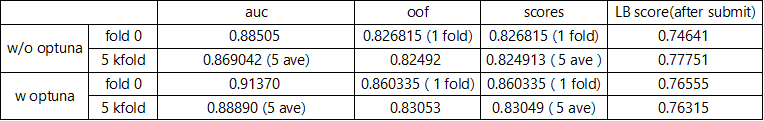

## 5 kfold without optuna is the best LB score. optuna may overfit.

5 kfoldのoptunaが一番良いスコアになりました。optunaは過学習しているのかもしれません。

# 9. Appendix : LGBM using custom metric

## 9.1 Custom Metric LGBM without optuna : fold 0, Submission 5

In [ ]:
def feval_accuracy(y_pred, lgb_train):
    
    y_true = lgb_train.get_label()
    
    y_pred = np.where(y_pred>=0.5,1,0)
    score = accuracy_score(y_true, y_pred)
    
    
    return 'Accuracy', score, True

In [ ]:
lgbm_params = {
    'objective': 'binary', 
    'seed': 42, 
    'metric': 'None', # Change here 
    "verbose":-1,
    "deterministic":True
}

In [ ]:
fix_seed(SEED) # for repetability

p_train = folds[folds["fold"] != 0]
p_val = folds[folds["fold"] == 0]

p_train = p_train.reset_index(drop=True)
p_val = p_val.reset_index(drop=True)

lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

cat_list = ['Embarked']


model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                  verbose_eval=50,  
                  num_boost_round=1000,  
                  early_stopping_rounds=100, 
                  categorical_feature = cat_list, 
                 feval = feval_accuracy # add here
                 )

import pickle

model_name = "LGBMmodel.bin"

# saving model
pickle.dump(model, open(model_name, 'wb'))

# loading model
model = pickle.load(open(model_name, 'rb'))

# predicting validation value
oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

oof_pred2 = np.where(oof_pred>=0.5,1,0)

accuracy_score(p_val[TARGET], oof_pred2)

# predicting for test_X
preds = model.predict(test_X[FEATURES])

preds2 = np.where(preds>=0.5,1,0)

### 0.826 → 0.849に上昇。

In [ ]:
submission["Survived"] = preds2
submission.to_csv("submission5.csv",index=False)

## 9.2 Custom Metric LGBM without optuna : 5 kfold , Submission 6

In [ ]:
scores = []
allpreds = []

allvaliddf = pd.DataFrame()


for fold in range(5):
    
    fix_seed(SEED) # for repetability

    p_train = folds[folds["fold"] != fold]
    p_val = folds[folds["fold"] == fold]

    p_train = p_train.reset_index(drop=True)
    p_val = p_val.reset_index(drop=True)

    lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
    lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

    cat_list = ['Embarked']


    model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                      verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
                      num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
                      early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
                      categorical_feature = cat_list, # manual categorical feature setting
                      feval = feval_accuracy # add here
                     )

    import pickle

    model_name = f"LGBMmodel{fold}.bin"

    # saving model
    pickle.dump(model, open(model_name, 'wb'))

    # loading model
    model = pickle.load(open(model_name, 'rb'))

    # predicting validation value
    oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

    oof_pred2 = np.where(oof_pred>=0.5,1,0)

    scores.append(accuracy_score(p_val[TARGET], oof_pred2))

    # predicting for test_X
    preds = model.predict(test_X[FEATURES])

    #preds2 = np.where(preds>=0.5,1,0)
    
    allpreds.append(preds)
    
    # out of fold : oof
    p_val["preds"] = oof_pred2
    
    allvaliddf = pd.concat([allvaliddf,p_val])
    
    

In [ ]:
scores

In [ ]:
np.mean(scores)

# 0.824 → 0.835に上昇

In [ ]:
allpreds = np.mean(allpreds,axis=0)
allpreds2 = np.where(allpreds>=0.5,1,0)
submission["Survived"] = allpreds2
submission.to_csv("submission6.csv",index=False)

## 9.2 Custom Metric Optuna with LGBM : fold = 0 , Submission 7

※ Optunalightgbmtunerしかoptunaのseed固定できませんが、custom metricが使えませんでした。そのため、通常版です。

In [ ]:
import optuna

In [ ]:
def objective_fold(num):
    
    
    def objective(trial):


        for fold in range(5):
            
            if fold != num:
                continue
                

            fix_seed(SEED) # for repetability

            p_train = folds[folds["fold"] != fold]
            p_val = folds[folds["fold"] == fold]

            p_train = p_train.reset_index(drop=True)
            p_val = p_val.reset_index(drop=True)

            lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
            lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

            cat_list = ['Embarked']




        #==== 最適化したいパラメータ ====
        lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0)
        lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)

        learning_rate = trial.suggest_uniform('learning_rate', 0, 1.0)

        feature_fraction = trial.suggest_uniform('feature_fraction', 0, 1.0)

        bagging_fraction = trial.suggest_uniform('bagging_fraction', 0, 1.0)
        bagging_freq = trial.suggest_int('bagging_freq', 5, 500)

        num_leaves = trial.suggest_int('num_leaves', 5, 1000)
        num_iterations = trial.suggest_int('num_iterations', 5, 1000)

        min_child_samples = trial.suggest_int('min_child_samples', 5, 500)
        min_child_weight = trial.suggest_int('min_child_weight', 5, 500)

        max_depth = trial.suggest_int('max_depth', 5, 100)

        #==== 定義したパラメータ ====

        lgbm_params = {
        'objective': 'binary', 
        'seed': 42, 
        'metric': 'None', # Change here 
        "lambda_l1": lambda_l1,
                  "lambda_l2": lambda_l2,
                  "learning_rate": learning_rate,
                  "feature_fraction": feature_fraction,
                  "bagging_fraction": bagging_fraction,
                  "bagging_freq": bagging_freq,
                  "num_leaves": num_leaves,
                  "num_iterations": num_iterations,
                  "min_child_samples": min_child_samples,
                  "min_child_weight": min_child_weight,
                  "max_depth": max_depth,
                  "verbosity": -1,
            "deterministic":True
        }



        model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                              verbose_eval=50,  # Learning result output every 50 iterations : 50イテレーション毎に学習結果出力
                              num_boost_round=1000,  # Specify the maximum number of iterations : 最大イテレーション回数指定
                              early_stopping_rounds=100, # Early stopping number : early stoppingを採用するiteration回数
                              categorical_feature = cat_list, # manual categorical feature setting
                              feval = feval_accuracy # add here
                             )



        oof_pred = model.predict(p_val[FEATURES])
        oof_pred2 = np.where(oof_pred>=0.5,1,0)


        score = accuracy_score(p_val[TARGET], oof_pred2)
        return score
    
    return objective

In [ ]:
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_fold(0), n_trials=100)

In [ ]:
trial = study.best_trial
print(trial.params)

lgbm_params = {
    'objective': 'binary', 
    'seed': 42, 
    'metric': 'None', # Change here 
    "verbose":-1,
    "deterministic":True
}
lgbm_params.update(**lgbm_params,**trial.params)
lgbm_params

### 9.2.1 Inference

In [ ]:
fix_seed(SEED) # for repetability

p_train = folds[folds["fold"] != 0]
p_val = folds[folds["fold"] == 0]

p_train = p_train.reset_index(drop=True)
p_val = p_val.reset_index(drop=True)

lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

cat_list = ['Embarked']


model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                  verbose_eval=50,  
                  num_boost_round=1000,  
                  early_stopping_rounds=100, 
                  categorical_feature = cat_list, 
                 feval = feval_accuracy # add here
                 )

import pickle

model_name = "LGBMmodel.bin"

# saving model
pickle.dump(model, open(model_name, 'wb'))

# loading model
model = pickle.load(open(model_name, 'rb'))

# predicting validation value
oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

oof_pred2 = np.where(oof_pred>=0.5,1,0)

accuracy_score(p_val[TARGET], oof_pred2)

# predicting for test_X
preds = model.predict(test_X[FEATURES])

preds2 = np.where(preds>=0.5,1,0)

In [ ]:
#allpreds = np.mean(allpreds,axis=0)
submission["Survived"] = preds2
submission.to_csv("submission7.csv",index=False)

## 9.3 Kfold with custom metric LGBM each fold optuna

In [ ]:
scores = []
allpreds = []

allvaliddf = pd.DataFrame()

for fold in range(5):
    


    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective_fold(fold), n_trials=100)

    trial = study.best_trial
    print(trial.params)

    lgbm_params = {
        'objective': 'binary', 
        'seed': 42, 
        'metric': 'None', # Change here 
        "verbose":-1,
        "deterministic":True
    }
    lgbm_params.update(**lgbm_params,**trial.params)
    lgbm_params

    fix_seed(SEED) # for repetability

    p_train = folds[folds["fold"] != 0]
    p_val = folds[folds["fold"] == 0]

    p_train = p_train.reset_index(drop=True)
    p_val = p_val.reset_index(drop=True)

    lgb_train = lgb.Dataset(p_train[FEATURES], p_train[TARGET])
    lgb_eval = lgb.Dataset(p_val[FEATURES], p_val[TARGET])

    cat_list = ['Embarked']


    model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                      verbose_eval=50,  
                      num_boost_round=1000,  
                      early_stopping_rounds=100, 
                      categorical_feature = cat_list, 
                     feval = feval_accuracy # add here
                     )

    import pickle

    model_name = "LGBMmodel.bin"

    # saving model
    pickle.dump(model, open(model_name, 'wb'))

    # loading model
    model = pickle.load(open(model_name, 'rb'))

    # predicting validation value
    oof_pred = model.predict(p_val[FEATURES], num_iteration=model.best_iteration)

    oof_pred2 = np.where(oof_pred>=0.5,1,0)

    scores.append(accuracy_score(p_val[TARGET], oof_pred2))

    # predicting for test_X
    preds = model.predict(test_X[FEATURES])
    
    #preds2 = np.where(preds>=0.5,1,0)
    
    allpreds.append(preds)
    
    # out of fold : oof
    p_val["preds"] = oof_pred2
    
    allvaliddf = pd.concat([allvaliddf,p_val])
    


In [ ]:
scores

In [ ]:
np.mean(scores)

### 0.835 → 0.849 に上昇

In [ ]:
accuracy_score(allvaliddf[TARGET],allvaliddf["preds"])

In [ ]:
allpreds = np.mean(allpreds,axis=0)
allpreds2 = np.where(allpreds>=0.5,1,0)
submission["Survived"] = allpreds2
submission.to_csv("submission8.csv",index=False)